# Introduction

The assignment was:
* Describe classification and regression ML algorithms and their typical representatives.
* Preparation of data sets for training, validation and testing.
* In the practical part of the paper analze the models for predicting the number of people in a room created using several
algorithms (classification and regression).
* Models need to be trained with data containing temperature, humidity, CO2 level, etc.
* For realization use Jupyter Notebook tool.
* Perform a comparative performance analysis of obtained models.

# Data importing

Importing all the necessary libraries:

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

Show raw data:

In [65]:
rawData = pd.read_csv("data.txt")
rawData.head()

,name,time,app_id,battery,co2,dev_id,hardware_serial,humidity,light,motion,person_count,temperature,time_device
0,co2_2,1.513170e+18,url_test,3631,559,co2_02,A81758FFFE030F06,37,76,1,7,212,2017-12-13T13:06:24.428788324Z
1,co2_2,1.513170e+18,url_test,3628,569,co2_02,A81758FFFE030F06,37,78,3,7,212,2017-12-13T13:07:24.422294045Z
2,co2_2,1.513170e+18,url_test,3628,588,co2_02,A81758FFFE030F06,37,73,1,7,213,2017-12-13T13:08:24.427909805Z
3,co2_2,1.513170e+18,url_test,3631,579,co2_02,A81758FFFE030F06,37,75,2,7,213,2017-12-13T13:09:24.409998484Z
4,co2_2,1.513170e+18,url_test,3631,565,co2_02,A81758FFFE030F06,37,77,1,7,213,2017-12-13T13:10:24.415049931Z


# Data analisys

Checking data types of columns:

In [66]:
print(rawData.dtypes)

name                object
time               float64
app_id              object
battery              int64
co2                  int64
dev_id              object
hardware_serial     object
humidity             int64
light                int64
motion               int64
person_count         int64
temperature          int64
time_device         object
dtype: object


Select relevant columns:

In [67]:
selectedData = rawData[['co2', 'humidity', 'light', 'motion', 'person_count', 'temperature', 'time_device']]

Let's check data values:

In [68]:
selectedData.describe()

,co2,humidity,light,motion,person_count,temperature
count,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000
mean,475.983508,34.059466,82.251336,0.533566,3.485947,221.316841
std,73.325450,5.223338,31.062353,0.833635,2.843026,6.112410
min,336.000000,19.000000,1.000000,0.000000,-1.000000,202.000000
25%,417.000000,31.000000,74.000000,0.000000,1.000000,219.000000
50%,464.000000,34.000000,81.000000,0.000000,3.000000,223.000000
75%,531.000000,37.000000,99.000000,1.000000,5.000000,225.000000
max,709.000000,47.000000,167.000000,3.000000,13.000000,233.000000


Number of rows and columns:

In [69]:
print(selectedData.shape)

(8610, 7)


Number of duplicate rows:

In [70]:
print(selectedData.duplicated().value_counts())

False    8610
Name: count, dtype: int64


Checking for null values:

In [71]:
if(selectedData.isnull().sum().all() > 0):
    print(selectedData.isnull().sum())
else:
    print("No null values!")

No null values!


There are rows where person_count is lower than 0, so they will be removed:

In [72]:
cleanedData = selectedData[selectedData['person_count'] >= 0]

Changing the format of time_device column so it is more suitable for ML:

In [73]:
def convert_month_day_hour(date_time):
    hour = date_time.split("T")[1].split("Z")[0][:8][:2]
    month_day = date_time.split("T")[0][5:]
    return int(month_day.replace("-", "") + hour)
month_day_hour = cleanedData['time_device'].apply(convert_month_day_hour)
timedData = cleanedData.drop(['time_device'], axis = 1)
timedData['month_day_hour'] = month_day_hour

In [74]:
data = timedData
data.describe(include='all')

,co2,humidity,light,motion,person_count,temperature,month_day_hour
count,8558.000000,8558.000000,8558.000000,8558.000000,8558.000000,8558.000000,8558.000000
mean,475.910493,34.053751,82.236387,0.531433,3.513204,221.381865,70589.161253
std,73.281980,5.236035,31.134211,0.832118,2.829997,6.067152,54847.753787
min,336.000000,19.000000,1.000000,0.000000,0.000000,202.000000,10208.000000
25%,416.000000,31.000000,74.000000,0.000000,1.000000,219.000000,11217.000000
50%,464.000000,34.000000,81.000000,0.000000,3.000000,223.000000,121412.000000
75%,531.000000,37.000000,99.000000,1.000000,5.000000,225.000000,122014.000000
max,709.000000,47.000000,167.000000,3.000000,13.000000,233.000000,122917.000000


Now, to see first few rows of prepared data:

In [75]:
data.head()

,co2,humidity,light,motion,person_count,temperature,month_day_hour
0,559,37,76,1,7,212,121313
1,569,37,78,3,7,212,121313
2,588,37,73,1,7,213,121313
3,579,37,75,2,7,213,121313
4,565,37,77,1,7,213,121313


## Scatter matrix

Plot of scatter matrix with respect to person_count column:

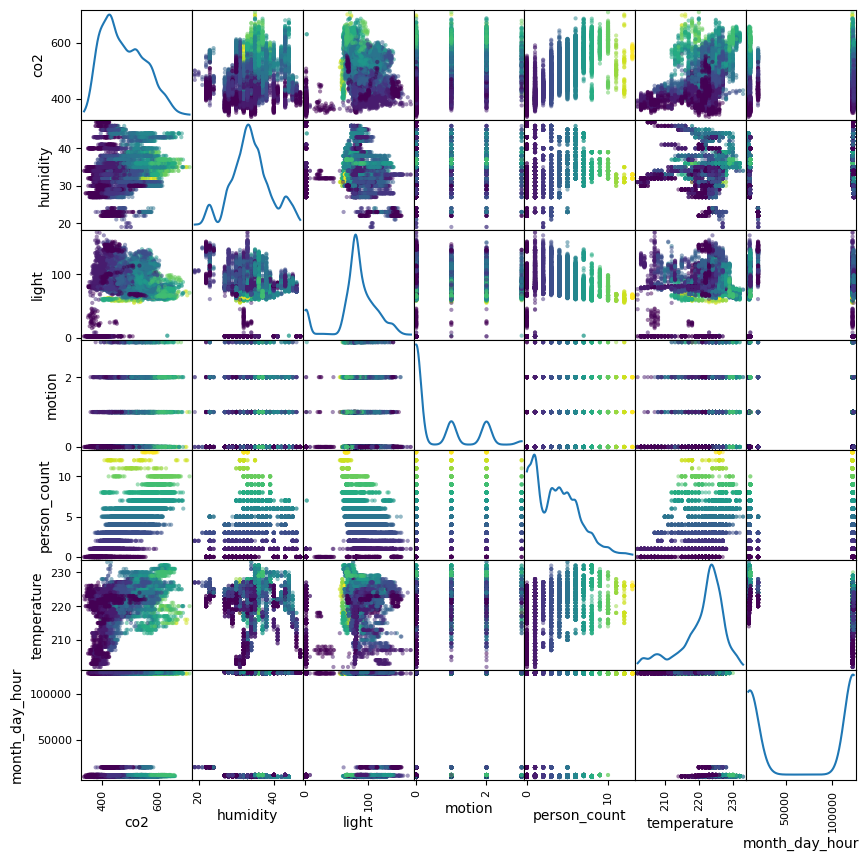

In [76]:
pd.plotting.scatter_matrix(timedData, c=timedData['person_count'], figsize=[10, 10], diagonal = 'kde')
plt.show()

## Correlation matrix

Plot of scatter matrix:

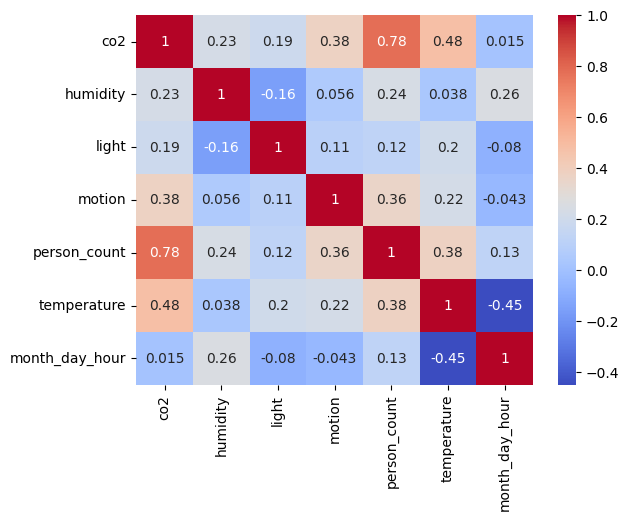

In [77]:
# Visualize the correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Modeling, Training and Testing

Following models will be used:
* Logistic Regression
* Naïve Bayes Classifier
* K-Nearest Neighbors Classifier
* Decision Tree Classifier
* Random Forest Classifier
* Gradient Boosting Machine Classifier
* Kernelized Support Vector Machine Classifier
* Light Gradient Boosting Machine Classifier
* Light Gradient Boosting Machine Regressor
* K-Nearest Neighbors Regressor

## Parameters:

In [78]:
THRESHOLD = 1      # THRESHOLD = 0 gives the same values as model.score()
DRAW = True        # Are confusion matrices going to be drawn
PRINT = True       # Are parameters going to be printed

## Preparing data sets:

In [79]:
x = data.drop('person_count', axis=1)
y = data['person_count']
X_train, X_test1, y_train, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X_train)
X1 = scaler.transform(X_test1)

## Helper functions:

In [80]:
def calculate_accuracy(y_test, y_pred, threshold):
    count = 0
    correct = 0
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    for i, line in enumerate(y_test):
        real = float(y_test[i])
        pred = float(y_pred[i])
        if(abs(real - pred) <= threshold):
            correct = correct + 1
        count = count + 1
    return float(correct)/count
def draw_confusion_matrix(X_test, y_test, y_pred):
    y_test = y_test.tolist()
    y_pred = y_pred.round(0).astype(float).tolist()
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.set_xlabel('Predicted outputs', color='black')
    ax.set_ylabel('Actual outputs', color='black')
    ax.xaxis.set(ticks=range(10))
    ax.yaxis.set(ticks=range(10))
    ax.set_ylim(9.5, -0.5)
    for i in range(10):
        for j in range(10):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
    plt.show()
def fit_and_analise(model, X, X1, y_train, y_test1, name):
    start_time = time.time()
    
    model.fit(X, y_train)
    y_pred = model.predict(X)
    y_pred1 = model.predict(X1)
    
    elapsed_time = time.time() - start_time
    train_accuracy = calculate_accuracy(y_pred, y_train, THRESHOLD)
    test_accuracy = calculate_accuracy(y_test1, y_pred1, THRESHOLD)
    
    if(PRINT == True):
        print(name + ":")
        print("     TIME: " + str(elapsed_time)[:5] + " seconds")
        print("    TRAIN: " + str(train_accuracy)[:5] + " %")
        print("     TEST: " + str(test_accuracy)[:5] + " %")
    if(DRAW == True):
        print("Training")
        draw_confusion_matrix(X, y_train, y_pred)
        print("Testing")
        draw_confusion_matrix(X1, y_test1, y_pred1)
        
    return [name, elapsed_time, train_accuracy, test_accuracy]

## Models:

Logistic Regression:
     TIME: 0.344 seconds
    TRAIN: 0.664 %
     TEST: 0.670 %
Training


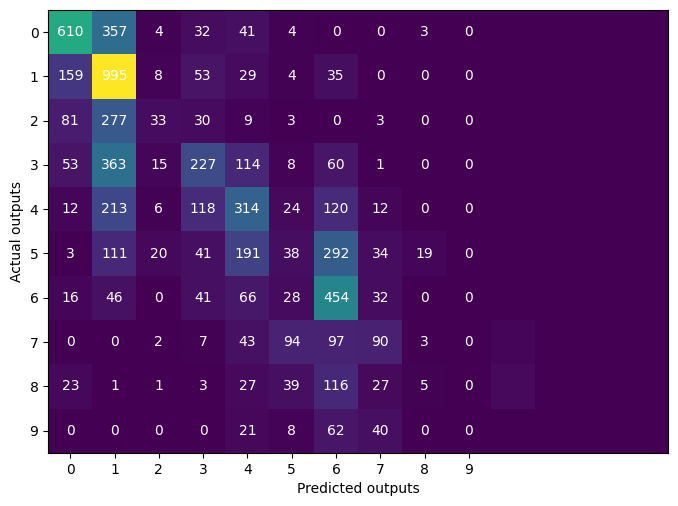

Testing


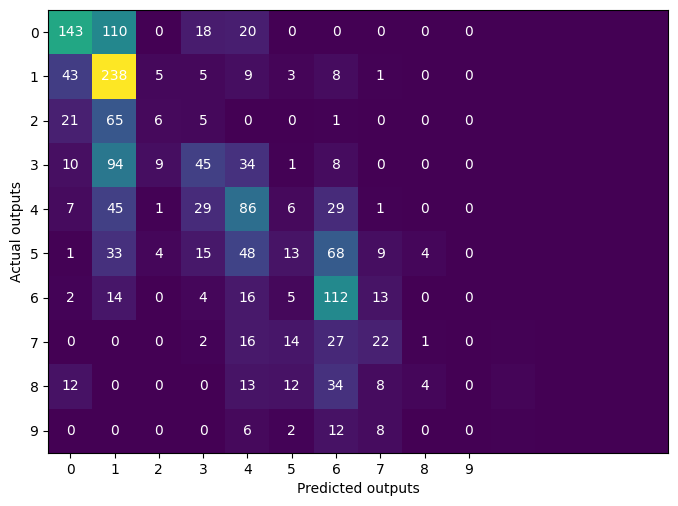

Gaussian Naive Bayes Classification:
     TIME: 0.026 seconds
    TRAIN: 0.715 %
     TEST: 0.703 %
Training


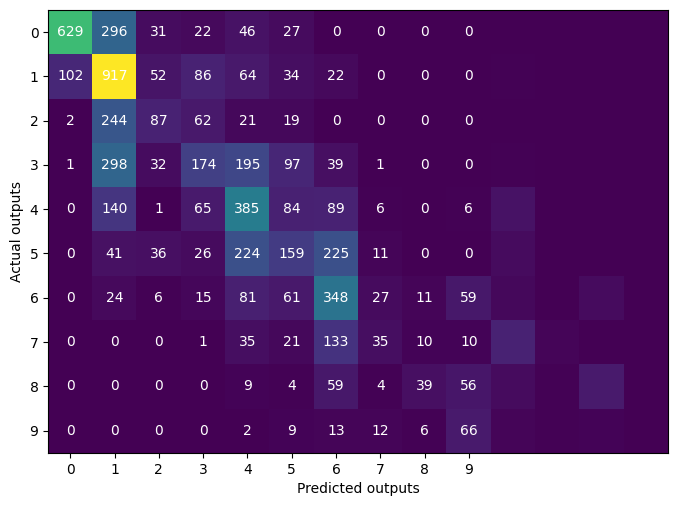

Testing


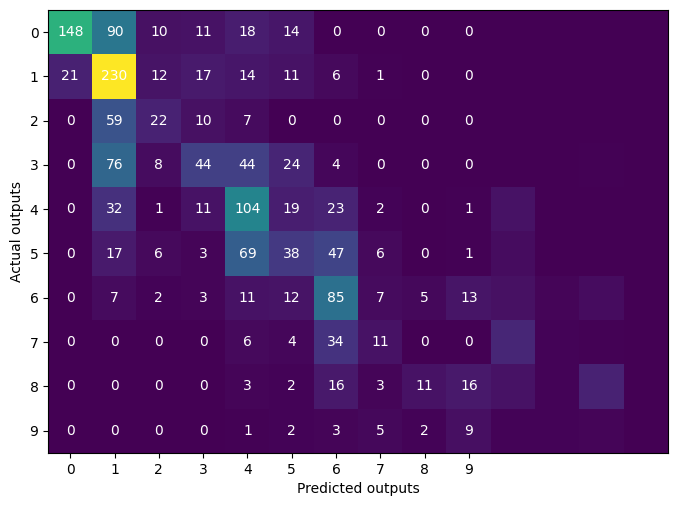

K-Neighbors Classification:
     TIME: 1.783 seconds
    TRAIN: 0.949 %
     TEST: 0.921 %
Training


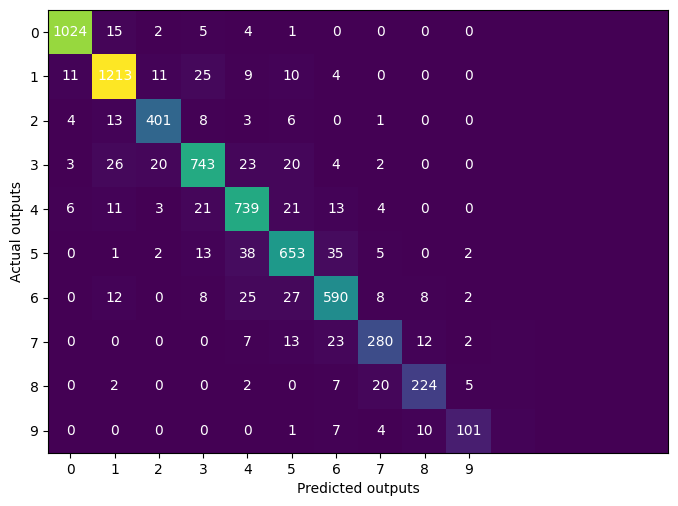

Testing


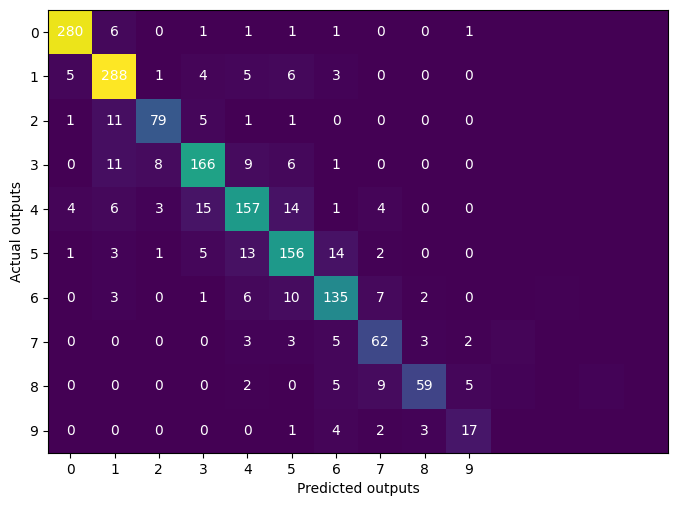

Decision Tree Classification:
     TIME: 0.070 seconds
    TRAIN: 1.0 %
     TEST: 0.957 %
Training


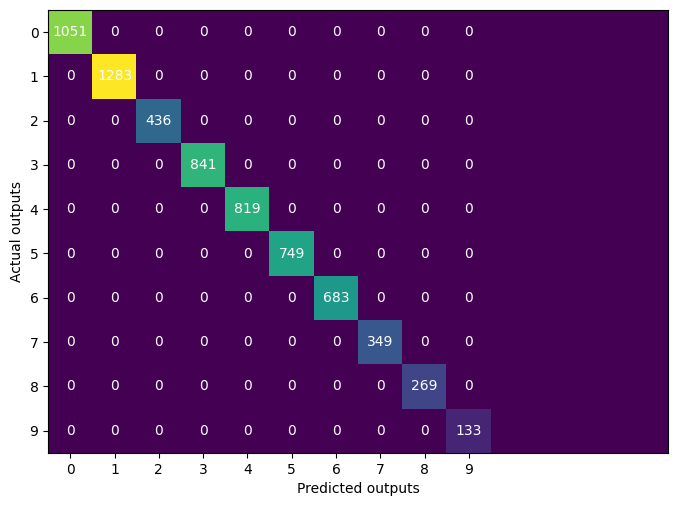

Testing


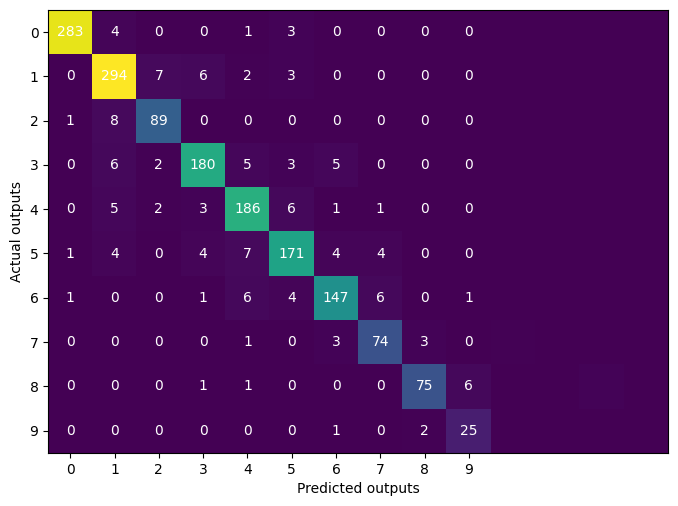

Random Forest Classification:
     TIME: 2.614 seconds
    TRAIN: 1.0 %
     TEST: 0.971 %
Training


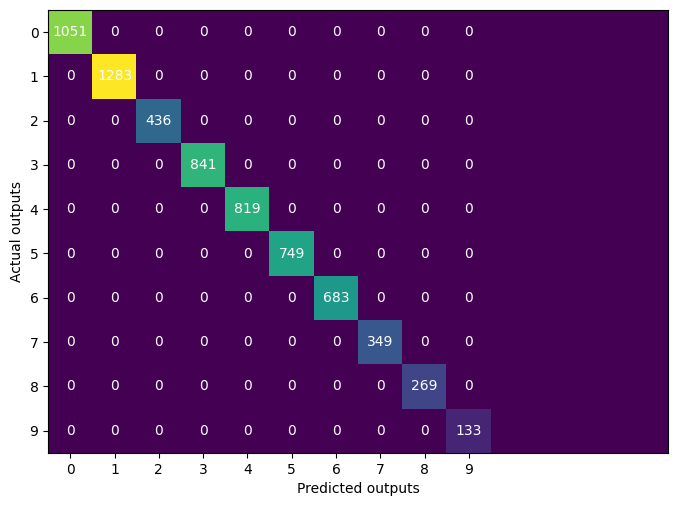

Testing


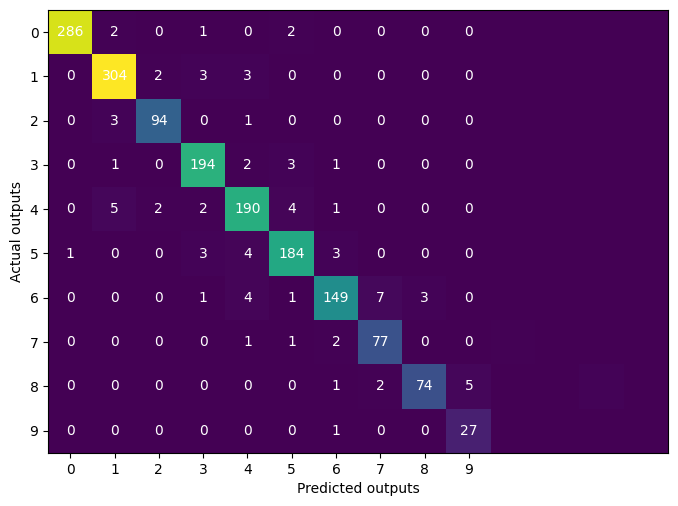

Gradient Boosting Classification:
     TIME: 30.26 seconds
    TRAIN: 0.977 %
     TEST: 0.964 %
Training


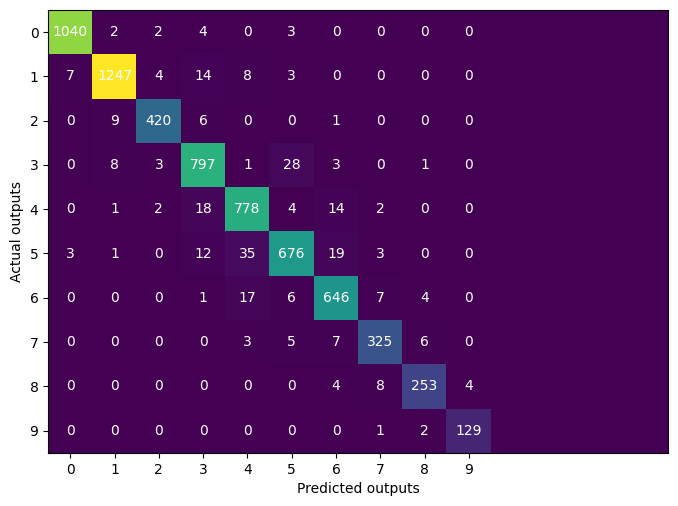

Testing


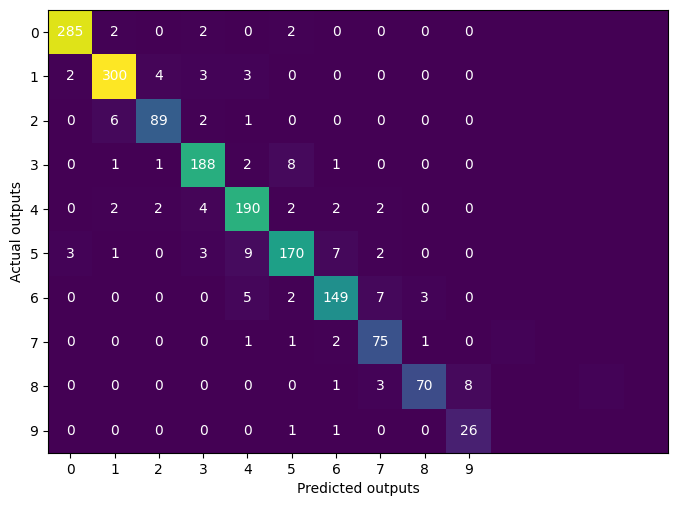

Support Vector Machine Classification:
     TIME: 14.76 seconds
    TRAIN: 0.830 %
     TEST: 0.817 %
Training


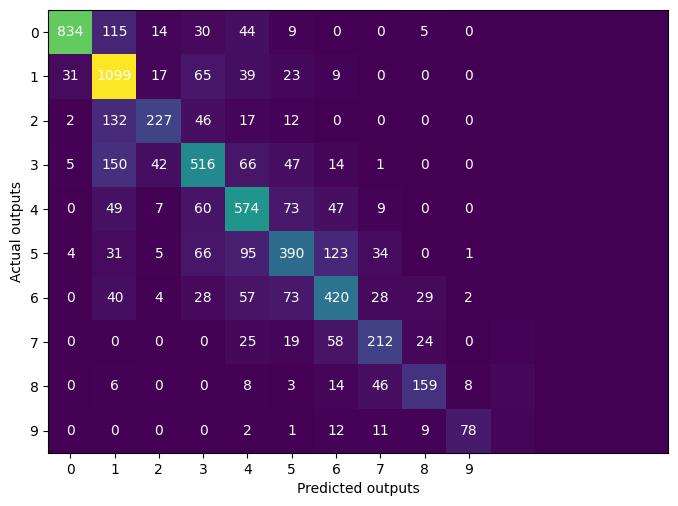

Testing


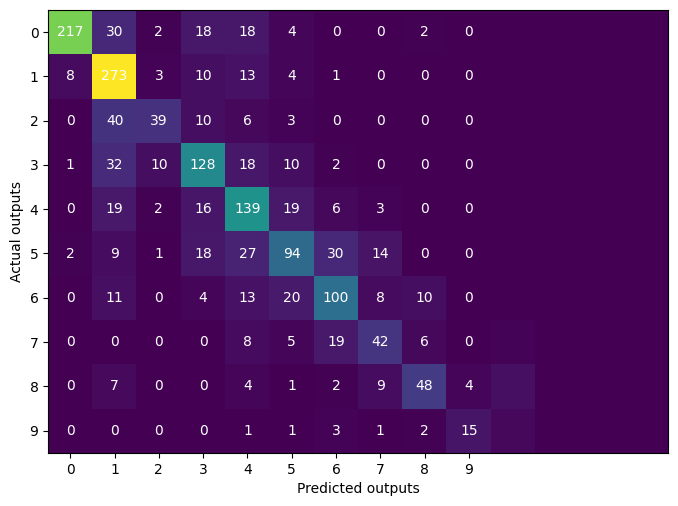

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 6846, number of used features: 6
[LightGBM] [Info] Start training from score -1.873922
[LightGBM] [Info] Start training from score -1.674463
[LightGBM] [Info] Start training from score -2.753778
[LightGBM] [Info] Start training from score -2.096828
[LightGBM] [Info] Start training from score -2.123336
[LightGBM] [Info] Start training from score -2.212681
[LightGBM] [Info] Start training from score -2.304925
[LightGBM] [Info] Start training from score -2.976348
[LightGBM] [Info] Start training from score -3.236708
[LightGBM] [Info] Start training from score -3.941071
[LightGBM] [Info] Start training from score -4.052296
[LightGBM] [Info] Start training from score -5.024757
[L

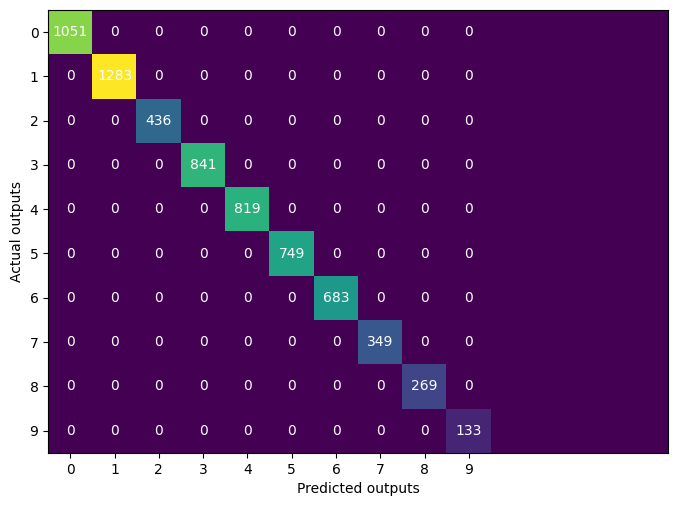

Testing


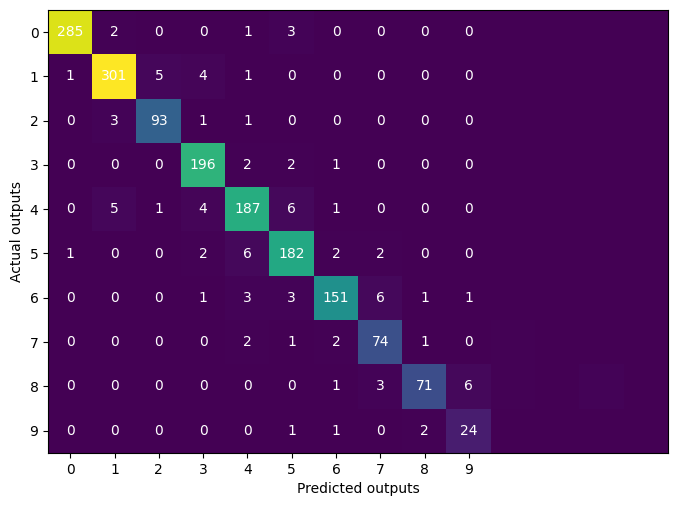

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 6846, number of used features: 6
[LightGBM] [Info] Start training from score 3.524248
Light Gradient Boosting Machine Regression:
     TIME: 0.306 seconds
    TRAIN: 0.948 %
     TEST: 0.919 %
Training


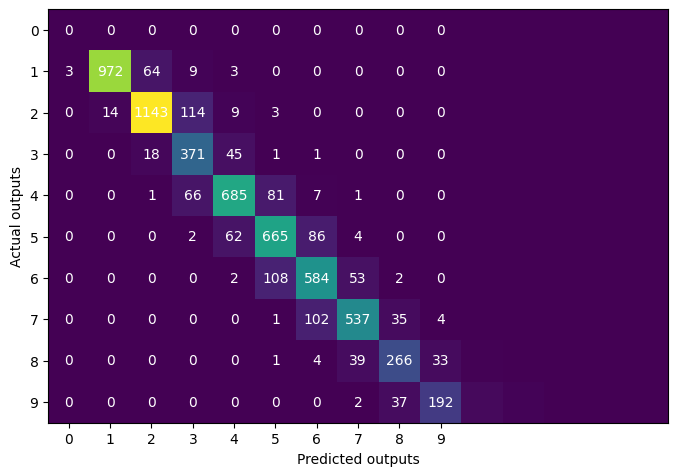

Testing


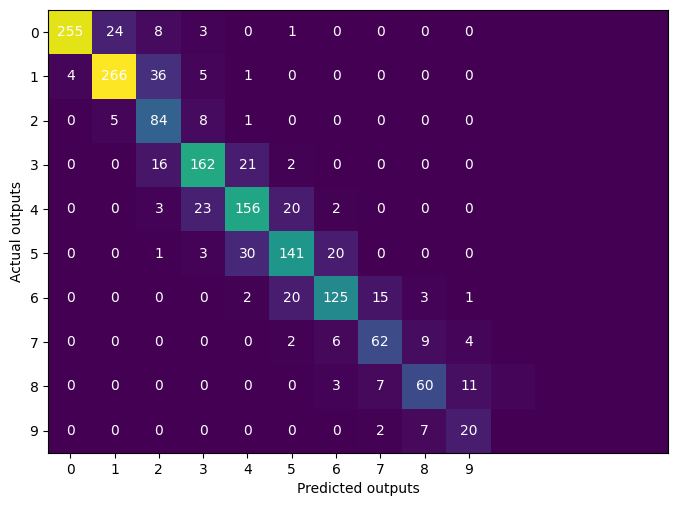

K-Neighbors Regression:
     TIME: 0.883 seconds
    TRAIN: 0.919 %
     TEST: 0.896 %
Training


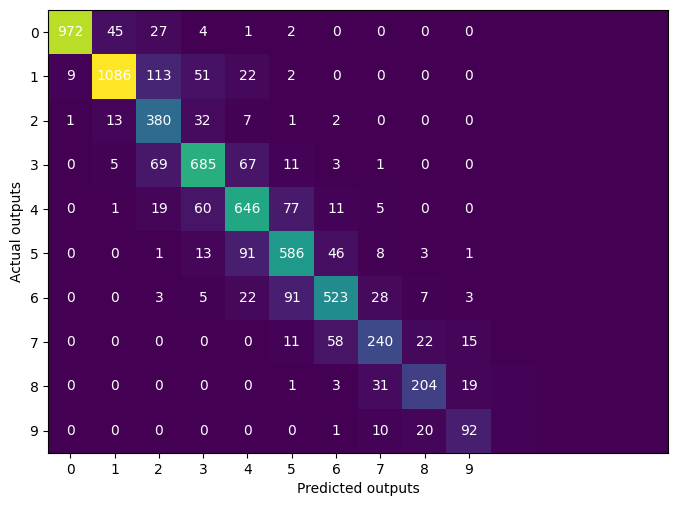

Testing


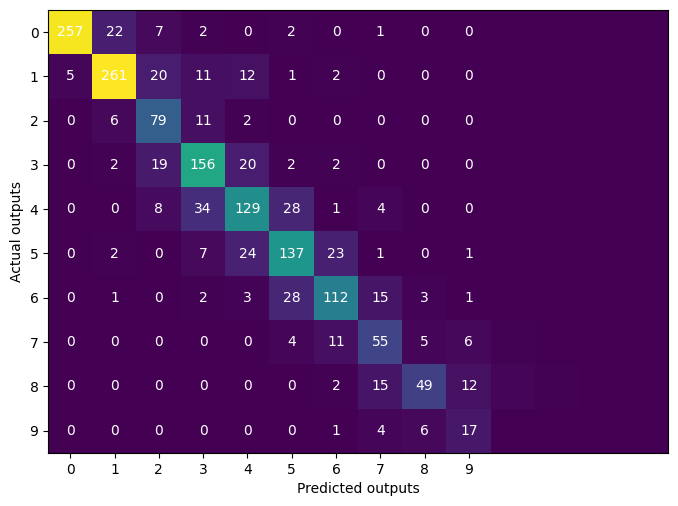

In [81]:
results = []

model = LogisticRegression(solver='liblinear', C=0.05, multi_class='ovr',random_state=0)
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "Logistic Regression"))

model = GaussianNB()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "Gaussian Naive Bayes Classification"))

model = KNeighborsClassifier()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "K-Neighbors Classification"))

model = DecisionTreeClassifier()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "Decision Tree Classification"))

model = RandomForestClassifier()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "Random Forest Classification"))

model = GradientBoostingClassifier()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "Gradient Boosting Classification"))

model = SVC()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "Support Vector Machine Classification"))

model = LGBMClassifier()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "Light Gradient Boosting Machine Classification"))

model = LGBMRegressor()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "Light Gradient Boosting Machine Regression"))

model = KNeighborsRegressor()
results.append(fit_and_analise(model, X, X1, y_train, y_test1, "K-Neighbors Regression"))

resultsFrame=pd.DataFrame(results,columns=['Algorithm','Time', 'Train accuracy', 'Test accuracy'])

In [82]:
print(resultsFrame)

                                        Algorithm       Time  Train accuracy  \
0                             Logistic Regression   0.344592        0.664768   
1             Gaussian Naive Bayes Classification   0.026917        0.715162   
2                      K-Neighbors Classification   1.783084        0.949313   
3                    Decision Tree Classification   0.070820        1.000000   
4                    Random Forest Classification   2.614001        1.000000   
5                Gradient Boosting Classification  30.263234        0.977067   
6           Support Vector Machine Classification  14.763555        0.830412   
7  Light Gradient Boosting Machine Classification   5.363167        1.000000   
8      Light Gradient Boosting Machine Regression   0.306436        0.948145   
9                          K-Neighbors Regression   0.883556        0.919369   

   Test accuracy  
0       0.670561  
1       0.703271  
2       0.921145  
3       0.957360  
4       0.971963  
5    

<Axes: title={'center': 'Time plot'}, ylabel='Algorithm'>

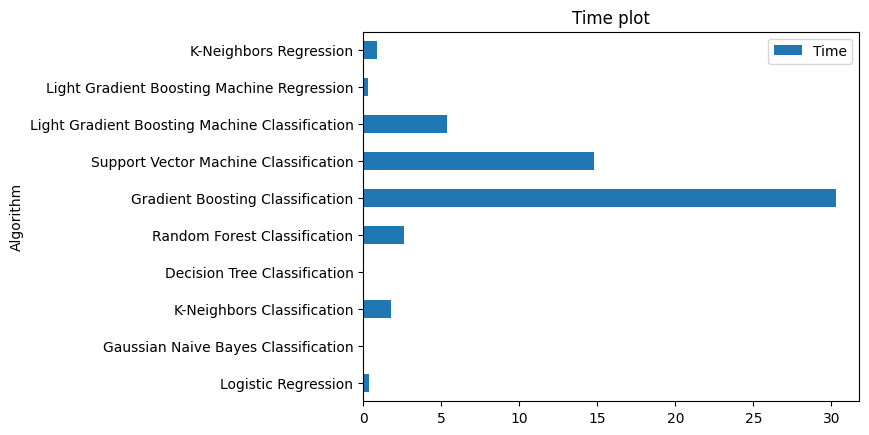

In [83]:
resultsFrame.plot(x = 'Algorithm', y = 'Time', kind = 'barh', title = "Time plot")

<Axes: title={'center': 'Accuracy plot'}, ylabel='Algorithm'>

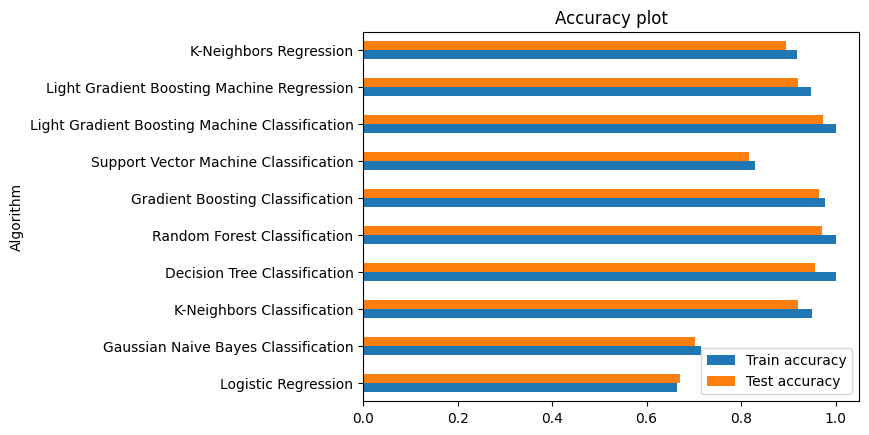

In [84]:
resultsFrame.plot(x = 'Algorithm', y = ['Train accuracy', 'Test accuracy'], kind = 'barh', title = "Accuracy plot")